# RetinaNet定量評価
## クラスの統合
以下の表のようにクラスを統合した。
<table>
    <tr>
        <th>統合前のクラス</th><th>統合後のクラス</th>
    </tr>
    <tr>
        <td>polyp</td><td rowspan=5>torose lesion</td>
    </tr>
    <tr>
        <td>nodule</td>
    </tr>
    <tr>
        <td>mass</td>
    </tr>
    <tr>
        <td>tumor</td>
    </tr>
    <tr>
        <td>SMT</td>
    </tr>
    <tr>
        <td>angioectasia</td><td rowspan=2>vascular lesion</td>
    </tr>
    <tr>
        <td>venous structure</td>
    </tr>
    <tr>
        <td>ulcer</td><td>ulcer</td>
    </tr>
</table>

In [28]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn.metrics
from pycocotools.cocoeval import COCOeval
from multiprocessing import Pool
import yaml
import json
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from retinanet.dataset import MedicalBboxDataset
from PIL import Image
from torchvision.transforms import Compose
from retinanet import transform as transf
import json
dataset_means = json.load(open(config['dataset']['mean_file']))
pd.options.display.precision = 4

config = yaml.safe_load(open('config.yaml'))

dataset_all = MedicalBboxDataset(
    config['dataset']['annotation_file'],
    config['dataset']['image_root'])
dataset_all = dataset_all.integrate_classes(
    config['dataset']['class_integration']['new'],
    config['dataset']['class_integration']['map'])
split_data = json.load(open(config['dataset']['split_file']))

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
creating index...
index created!


## 病変ごとの画像枚数
データセットを5分割する、5-foldのクロスバリデーションを行なった。  
分割したうちの1つをtestデータにし、残りの4つをtrainデータにしてモデルを学習する。  
そのため、データセット分割の異なる5パターンの実験ができる。

以下の表はそれぞれの分割についての画像枚数。

In [29]:
summary = pd.DataFrame(index=['normal']+dataset_all.get_category_names()+['合計'])

for split in range(len(split_data['image_id'])):
    train = dataset_all.split(split, config['dataset']['split_file'])
    summary[split] = \
        [len(train.without_annotation())] + \
        [len(train.coco.getImgIds(catIds=catid)) for catid in train.coco.getCatIds()] + \
        [len(train)]

summary['sum'] = summary.sum(axis=1)
summary

creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!


,0,1,2,3,4,sum
normal,5914,6572,7379,7781,6791,34437
torose lesion,982,914,820,1101,773,4590
vascular lesion,75,141,94,77,151,538
ulcer,76,76,76,75,95,398
合計,7047,7703,8369,9034,7810,39963


## 病変ごとの患者数

In [30]:
patient_to_imgids = {}

for image in dataset_all.coco.dataset['images']:
    patid = image['patient_id']
    if not patid in patient_to_imgids:
        patient_to_imgids[patid] = []
    patient_to_imgids[patid].append(image['id'])

In [31]:
summary = pd.DataFrame(index=['normal']+train.get_category_names()+['合計'])

for split in range(len(split_data['image_id'])):
    summary[split] = 0
    for patid in split_data['patient_id'][split]:
        annids = dataset_all.coco.getAnnIds(imgIds=patient_to_imgids[patid])
        cats = set(ann['category_id'] for ann in dataset_all.coco.loadAnns(annids))
        if len(cats) == 0:
            summary[split]['normal'] += 1
        for cat in cats:
            summary[split][dataset_all.coco.loadCats(cat)[0]['name']] += 1
        summary[split]['合計'] += 1

summary['sum'] = summary.sum(axis=1)
summary

,0,1,2,3,4,sum
normal,2,2,2,3,2,11
torose lesion,13,12,6,17,16,64
vascular lesion,12,11,10,12,11,56
ulcer,10,10,9,11,1,41
合計,35,34,27,42,29,167


# 定量評価
## 平均・標準偏差・95%信頼区間
ほとんどの指標について、平均・標準偏差・95%信頼区間を計算する。

- 平均 (average): 病変ごとの平均、分割ごとの平均共に計算
- 標準偏差 (std): 分割ごとの標本分散の平方根
- 95%信頼区間 (95% CI): t分布を使用した母集団平均区間推定
- 母分散を既知とした場合の95%信頼区間 (norm 95% CI): 上で求めた分散と母分散とのずれが無いとした時の母集団平均区間推定

In [32]:
def add_average_columns(summary):
    summary.loc['average'] = summary.mean(axis='rows')
    n = len(summary.columns)
    average = summary.mean(axis='columns')
    std = summary.std(axis='columns')
    
    def calc_t95ci(row):
        if row['std'] == 0.:
            low, high = row['average'], row['average']
        else:
            t_dist = stats.t(loc=row['average'], scale=row['std']/np.sqrt(n-1), df=n-1)
            low, high = t_dist.interval(alpha=0.95)
        return '{:.4f} - {:.4f}'.format(low, high)
    
    def calc_norm95ci(row):
        if row['std'] == 0.:
            low, high = row['average'], row['average']
        else:
            norm_dist = stats.norm(loc=row['average'], scale=row['std']/np.sqrt(n))
            low, high = norm_dist.interval(alpha=0.95)
        return '{:.4f} - {:.4f}'.format(low, high)
        
    summary['average'] = average
    summary['std'] = std
    summary['95% CI'] = summary.apply(calc_t95ci, axis=1)
    summary['norm 95% CI'] = summary.apply(calc_norm95ci, axis=1)

## 重なり具合(IoU)を使用したボックスレベルの評価

In [36]:
import os
#eval_path = f'/data/unagi0/masaoka/retinanet/bbox_results{val}.json'

iouthrs = np.arange(0, 1, 0.05)
iouthrs[0] = 1e-6


def calc_scores(split):
    eval_path = f'/data/unagi0/masaoka/retinanet/bbox_results{split}.json'
    val_coco = dataset_all.split(split, config['dataset']['split_file'])
    transform = Compose([
        transf.ToFixedSize([config['inputsize']] * 2),  # inputsize x inputsizeの画像に変換
        transf.Normalize(dataset_means['mean'], dataset_means['std']),
        transf.HWCToCHW()
        ])
    val_coco.set_transform(transform)
    coco_true = val_coco.coco
    coco_result = coco_true.loadRes(eval_path)
    evaluator = COCOeval(coco_true, coco_result, iouType='bbox')

    evaluator.params.iouThrs = iouthrs
    
    evaluator.evaluate()
    evaluator.accumulate()

    maps = []
    for iou in iouthrs:
        t = np.where(evaluator.params.iouThrs == iou)[0][0]
        s = evaluator.eval['precision']
        s = s[t, :, :, evaluator.params.areaRngLbl.index('all'), evaluator.params.maxDets.index(100)]
        maps.append(s.mean(axis=0).tolist())
    return maps

maps = []
for map_split in map(calc_scores, range(len(split_data['image_id']))):
        maps.append(map_split)

maps = np.array(maps)
"""
maps = []
for i in  range(1):
    map_split = calc_scores(0)
    maps.append(map_split)

maps = np.array(maps)"""

creating index...
index created!
Loading and preparing results...
DONE (t=3.86s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=13.69s).
Accumulating evaluation results...
DONE (t=12.55s).
creating index...
index created!
Loading and preparing results...
DONE (t=4.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.59s).
Accumulating evaluation results...
DONE (t=13.67s).
creating index...
index created!
Loading and preparing results...
DONE (t=5.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.22s).
Accumulating evaluation results...
DONE (t=16.60s).
creating index...
index created!
Loading and preparing results...
DONE (t=4.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.44s).
Accumulating evaluation results...
DONE (t=14.80s).
creating ind

'\nmaps = []\nfor i in  range(1):\n    map_split = calc_scores(0)\n    maps.append(map_split)\n\nmaps = np.array(maps)'

### mAP@IoU=.5
重なり具合(IoU)が0.5を超え、かつラベルも正しいときにのみ正しいとした時のAverage Precision。  
IoUの計算方法は以下の図を参照。

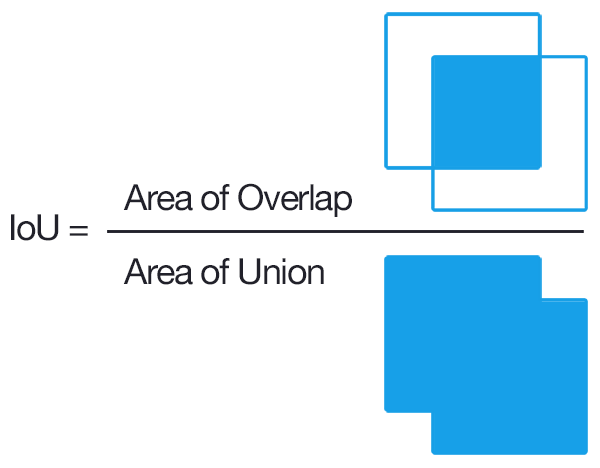

参考：IoUの0.1～0.9を図にしてみた  
https://qiita.com/ak11/items/8e0f42f358c1f822df27

In [37]:
summary = maps[:, iouthrs == 0.5][:, 0].T
summary = pd.DataFrame(summary, index=train.get_category_names())
add_average_columns(summary)
summary

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.7581,0.7552,0.8208,0.6968,0.1910,0.6444,0.2572,0.2873 - 1.0014,0.4189 - 0.8698
vascular lesion,0.8962,0.8228,0.7887,0.8195,0.0044,0.6663,0.3721,0.1497 - 1.1829,0.3401 - 0.9925
ulcer,0.8482,0.8583,0.8507,0.8874,0.1997,0.7289,0.2962,0.3176 - 1.1401,0.4692 - 0.9885
average,0.8342,0.8121,0.8201,0.8012,0.1317,0.6798,0.3067,0.2541 - 1.1056,0.4110 - 0.9486


### mAP@IoU=.0
少しでも教師データと重なれば正しいとした時のAverage Precision

In [38]:
summary = maps[:, 0].T
summary = pd.DataFrame(summary, index=train.get_category_names())
add_average_columns(summary)
summary

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.7684,0.7649,0.8261,0.7098,0.2992,0.6737,0.2133,0.3775 - 0.9699,0.4867 - 0.8607
vascular lesion,0.9083,0.8321,0.7937,0.8207,0.0161,0.6742,0.3704,0.1600 - 1.1883,0.3496 - 0.9988
ulcer,0.8723,0.8737,0.9156,0.9250,0.5797,0.8333,0.1438,0.6337 - 1.0328,0.7072 - 0.9593
average,0.8497,0.8235,0.8452,0.8185,0.2983,0.7270,0.2400,0.3938 - 1.0603,0.5166 - 0.9374


### mAP@IoU=x
横軸に重なり具合の閾値、縦軸にAverage Precisionをとったグラフ

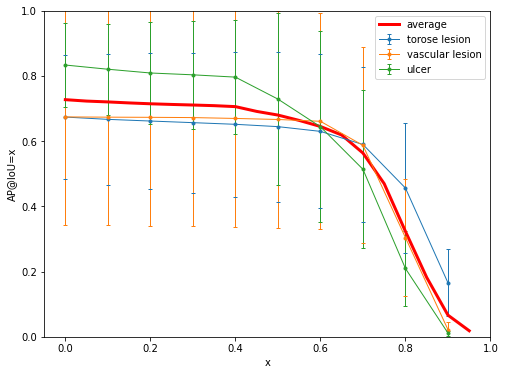

In [39]:
plt.figure(figsize=(8,6))

for map_l, label in zip(maps.transpose(2,1,0), train.get_category_names()):
    e = map_l.std(axis=-1)
    y = map_l.mean(axis=-1)
    plt.errorbar(iouthrs[::2], y[::2], yerr=e[::2], marker='.', capthick=1, capsize=2, lw=1, label=label)
plt.plot(iouthrs, maps.mean(axis=(0, 2)), label='average', linewidth=3.0, c='r')
plt.legend()
plt.xlabel('x')
plt.ylabel('AP@IoU=x')
plt.xlim(-0.05, 1)
plt.ylim(0, 1)
plt.show()

## 画像単位の定量評価

各病変ごとに評価を行う。
- 評価したい病変のない画像について
 - ボックスが出力されていなければTrue Negative
 - ボックスが一つでも出力されればFalse Positive
- 評価したい病変のある画像について
 - アノテーションと少しでも重なるボックスがあればTrue Positive
 - ボックスが出力されていても、アノテーションと重なっているボックスがなければFalse Negative

病変がない画像については**ボックスが出力されればPositive**として評価される一方、  
病変がある画像については**ボックスが出力されてもアノテーションと重なっていなければNegative**として評価される点に注意。

この設定は患者単位の評価にも引き継がれる。

In [40]:
def calc_scores(split):
    eval_path = f'/data/unagi0/masaoka/retinanet/bbox_results{split}.json'
    val_coco = dataset_all.split(split, config['dataset']['split_file']).coco
    coco_result = val_coco.loadRes(eval_path)
    
    ### ボックスの重なりを考慮する部分（考慮しないのであればコメントアウト）
    """evaluator = COCOeval(val_coco, coco_result, iouType='bbox')
    evaluator.evaluate()"""
    ### ボックスの重なりを考慮する部分（ここまで）

    imglevel_gts = []
    imglevel_prs = []
    imglevel_pid = []

    for imgid in val_coco.getImgIds():
        gts_c = val_coco.loadAnns(val_coco.getAnnIds(imgIds=imgid))
        prs_c = coco_result.loadAnns(coco_result.getAnnIds(imgIds=imgid))
        pid = val_coco.loadImgs(imgid)[0]['patient_id']
        gts = [0] * len(val_coco.getCatIds())
        prs = [.0] * len(val_coco.getCatIds())

        for gtc in gts_c:
            cat = val_coco.getCatIds().index(gtc['category_id'])
            gts[cat] = 1
            
        for prc in prs_c:
            cat = val_coco.getCatIds().index(prc['category_id'])
            score = prc['score']
            if prs[cat] < score:
                prs[cat] = score

        ### ボックスの重なりを考慮する部分（考慮しないのであればコメントアウト）
        """iou_thresh = .0
        for catidx, exist in enumerate(gts):
            if prs[catidx] > 0 and exist:
                catid = val_coco.getCatIds()[catidx]
                matched = np.any(evaluator.ious[(imgid, catid)] > iou_thresh, axis=1)
                dt = evaluator._dts[imgid, catid]
                inds = np.argsort([-d['score'] for d in dt], kind='mergesort')
                dt = [dt[i] for i in inds]
                scores = np.array([d['score'] for d in dt])
                prs[catidx] = scores[matched].max()"""
        ### ボックスの重なりを考慮する部分（ここまで）

        imglevel_gts.append(gts)
        imglevel_prs.append(prs)
        imglevel_pid.append(pid)
    
    return np.array(imglevel_gts), np.array(imglevel_prs), np.array(imglevel_pid)

maps = []
for map_split in map(calc_scores, range(len(split_data['image_id']))):
    maps.append(map_split)

imglevel_gts_all = []
imglevel_prs_all = []
imglevel_pid_all = []

for imglevel_gts, imglevel_prs, imglevel_pid in maps:
    imglevel_gts_all.append(np.array(imglevel_gts))
    imglevel_prs_all.append(np.array(imglevel_prs))
    imglevel_pid_all.append(np.array(imglevel_pid))

creating index...
index created!
Loading and preparing results...
DONE (t=4.44s)
creating index...
index created!
creating index...
index created!
Loading and preparing results...
DONE (t=4.29s)
creating index...
index created!
creating index...
index created!
Loading and preparing results...
DONE (t=5.08s)
creating index...
index created!
creating index...
index created!
Loading and preparing results...
DONE (t=4.35s)
creating index...
index created!
creating index...
index created!
Loading and preparing results...
DONE (t=4.56s)
creating index...
index created!


### AP(他の病変も含んだ状態での評価)
例えばtorose lesionを評価するとき、vascular lesionとulcerの画像は正常画像と同じくtorose lesionではない画像として扱う。

In [42]:
summary = pd.DataFrame(index=train.get_category_names())
for split in range(5):
    aps = []
    imglevel_gts = imglevel_gts_all[split]
    imglevel_prs = imglevel_prs_all[split]
    for cat in range(imglevel_gts.shape[1]):
        aps.append(sklearn.metrics.average_precision_score(imglevel_gts[:, cat], imglevel_prs[:, cat]))
    summary[split] = aps

add_average_columns(summary)
summary

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.8000,0.8375,0.8388,0.7709,0.3603,0.7215,0.2039,0.4384 - 1.0045,0.5428 - 0.9002
vascular lesion,0.9082,0.8711,0.8018,0.8235,0.0326,0.6874,0.3684,0.1760 - 1.1989,0.3645 - 1.0104
ulcer,1.0000,0.9997,0.9947,0.9991,0.8044,0.9596,0.0868,0.8391 - 1.0801,0.8835 - 1.0356
average,0.9027,0.9028,0.8784,0.8645,0.3991,0.7895,0.2189,0.4857 - 1.0933,0.5977 - 0.9813


### ROC-AUC(他の病変も含んだ評価)

In [43]:
summary = pd.DataFrame(index=train.get_category_names())
for split in range(len(split_data['image_id'])):
    rocaucs = []
    imglevel_gts = imglevel_gts_all[split]
    imglevel_prs = imglevel_prs_all[split]
    for cat in range(imglevel_gts.shape[1]):
        rocaucs.append(sklearn.metrics.roc_auc_score(imglevel_gts[:, cat], imglevel_prs[:, cat]))
    summary[split] = rocaucs

add_average_columns(summary)
summary

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.9452,0.9566,0.9663,0.9470,0.7555,0.9141,0.0891,0.7904 - 1.0378,0.8360 - 0.9922
vascular lesion,0.9940,0.9836,0.9914,0.9891,0.6724,0.9261,0.1419,0.7291 - 1.1231,0.8017 - 1.0505
ulcer,1.0000,1.0000,1.0000,1.0000,0.9980,0.9996,0.0009,0.9984 - 1.0008,0.9988 - 1.0004
average,0.9797,0.9801,0.9859,0.9787,0.8086,0.9466,0.0772,0.8394 - 1.0537,0.8789 - 1.0142


### ROC-AUC(他の病変を含まない評価)
例えばtorose lesionを評価するとき、vascular lesionとulcerの画像を取り除く  
*Automatic detection of erosions and ulcerations in wirelesscapsule endoscopy images based on a deep convolutionalneural network*と比較するのにフェアだと思う

ちなみに上記の論文ではデータセットは異なるがulcerでROC-AUC = 0.958 (95% CI , 0.947-0.968)

In [44]:
summary = pd.DataFrame(index=train.get_category_names())
for split in range(len(split_data['image_id'])):
    rocaucs = []
    imglevel_gts = imglevel_gts_all[split]
    imglevel_prs = imglevel_prs_all[split]
    for cat in range(imglevel_gts.shape[1]):
        mask = imglevel_gts[:, cat].astype(bool) | ~ imglevel_gts.any(axis=1)
        rocaucs.append(sklearn.metrics.roc_auc_score(imglevel_gts[mask, cat], imglevel_prs[mask, cat]))
    summary[split] = rocaucs

add_average_columns(summary)
summary

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.9438,0.9552,0.9656,0.9460,0.7508,0.9123,0.0907,0.7864 - 1.0381,0.8328 - 0.9918
vascular lesion,0.9931,0.9814,0.9904,0.9875,0.6437,0.9192,0.1541,0.7054 - 1.1331,0.7842 - 1.0543
ulcer,1.0000,1.0000,1.0000,1.0000,0.9985,0.9997,0.0007,0.9988 - 1.0006,0.9991 - 1.0003
average,0.9790,0.9789,0.9853,0.9778,0.7977,0.9437,0.0817,0.8303 - 1.0571,0.8721 - 1.0153


### ROCカーブ
縦軸が感度$\frac{TP}{TP+FN}$、横軸が$\frac{FP}{TN+FP}$  
図を論文で使用するため、ここだけ分割のIndexを1から始めている。

#### torose lesion

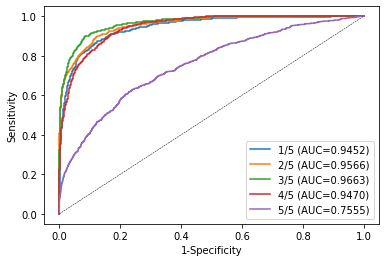

#### vascular lesion

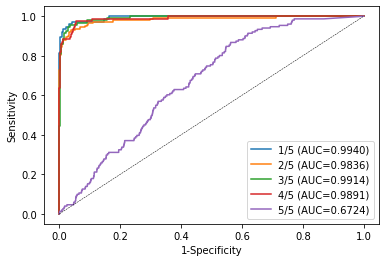

#### ulcer

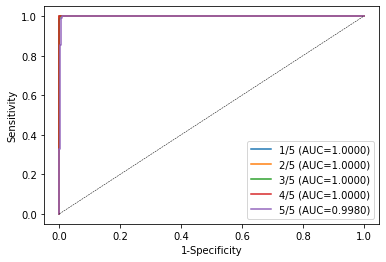

In [45]:
for i, labelname in enumerate(train.get_category_names()):
    plt.figure(figsize=(6,4))
    for split in range(len(split_data['image_id'])):
        imglevel_gts = imglevel_gts_all[split]
        imglevel_prs = imglevel_prs_all[split]
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(imglevel_gts[:, i], imglevel_prs[:, i])
        plt.plot(fpr, tpr, linewidth=1.5,
            label='{}/{} (AUC={:.4f})'.format(
                split+1,
                len(split_data['image_id']),
                sklearn.metrics.roc_auc_score(imglevel_gts[:, i], imglevel_prs[:, i])))

    plt.plot([0,1], [0,1], color='black', linewidth=0.5, linestyle='dashed')
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    display(Markdown('#### ' + labelname))
    plt.show()

### Confusion Matrix
感度+特異度が最大になる点を適切な閾値とする (Youden index)

表は以下のような順番で書かれている。
<table>
    <tr>
        <th></th>
        <th></th>
        <th colspan=2>Predict</th>
    </tr>
    <tr>
        <th></th>
        <th></th>
        <th>Positive</th>
        <th>Negative</th>
    </tr>
    <tr>
        <th rowspan=2>Ground Truth</th>
        <th>Positive</th>
        <td>TP</td><td>FN</td>
    </tr>
    <tr>
        <th>Negative</th>
        <td>FP</td><td>TN</td>
    </tr>
</table>

In [46]:
def youden(gt, pr):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(gt, pr)
    ss = tpr + (1 - fpr)
    i = np.argmax(ss)
    return thresholds[i]

confusion_matrix = []
imglevel_prsth_all = [np.empty_like(x) for x in imglevel_gts_all]
for i in range(len(train.get_category_names())):
    cfm = []
    for split in range(len(split_data['image_id'])):
        imglevel_gts = imglevel_gts_all[split][:, i]
        imglevel_prs = imglevel_prs_all[split][:, i]
        imglevel_prsth = imglevel_prsth_all[split][:, i]
        thresh = youden(imglevel_gts, imglevel_prs)
        imglevel_prsth[:] = imglevel_prs>thresh
        cfm.append(sklearn.metrics.confusion_matrix(imglevel_gts, imglevel_prsth))
    confusion_matrix.append(cfm)
confusion_matrix = np.array(confusion_matrix)

# print confusion matrix
for i, labelname in enumerate(train.get_category_names()):
    fold = confusion_matrix[i][:, ::-1, ::-1].transpose(1, 0, 2).reshape(2, -1)
    summation = confusion_matrix[i].sum(axis=0)[::-1, ::-1]
    display(
        Markdown('#### ' + labelname),
        pd.DataFrame(
            np.hstack([fold, summation]),
            index=['P', 'N'],
            columns=pd.MultiIndex.from_product([list(range(5))+['sum'], ['P', 'N']]))
    )

#### torose lesion

0          1          2           3           4         sum       
     P     N    P     N    P     N     P     N     P     N     P      N
P  856   126  820    94  734    86  1002    99   486   287  3898    692
N  753  5312  830  5959  630  6919  1374  6559  1689  5348  5276  30097

#### vascular lesion

0          1          2          3           4         sum       
     P     N    P     N    P     N    P     N     P     N     P      N
P   72     3  130    11   89     5   74     3   130    21   495     43
N  295  6677  287  7275  287  7988  496  8461  4311  3348  5676  33749

#### ulcer

0         1         2         3         4        sum       
    P     N   P     N   P     N   P     N   P     N    P      N
P  75     1  75     1  75     1  74     1  94     1  393      5
N   0  6971   2  7625   7  8286   3  8956  63  7652   75  39490

### 正解率(Accuracy)・感度(Recall)・特異度(Specificity)
上記のConfusion Matrixに基づいている。

\begin{eqnarray}
Accuracy &=& \frac{TP+TN}{TP+TN+FP+FN} \\
Recall &=& \frac{TP}{TP+FN} \\
Specificity &=& \frac{TN}{TN+FP}
\end{eqnarray}

In [47]:
tn = confusion_matrix[:, :, 0, 0]
fp = confusion_matrix[:, :, 0, 1]
fn = confusion_matrix[:, :, 1, 0]
tp = confusion_matrix[:, :, 1, 1]

accuracy = pd.DataFrame((tp + tn) / (tp + tn + fp + fn), index=train.get_category_names())
add_average_columns(accuracy)
display(Markdown('#### Accuracy'), accuracy)

recall = pd.DataFrame(tp / (tp + fn), index=train.get_category_names())
add_average_columns(recall)
display(Markdown('#### Recall'), recall)

specificity = pd.DataFrame(tn / (tn + fp), index=train.get_category_names())
add_average_columns(specificity)
display(Markdown('#### Specificity'), specificity)

#### Accuracy

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.8753,0.8800,0.9144,0.8369,0.7470,0.8507,0.0642,0.7617 - 0.9398,0.7945 - 0.9070
vascular lesion,0.9577,0.9613,0.9651,0.9448,0.4453,0.8548,0.2291,0.5369 - 1.1728,0.6541 - 1.0556
ulcer,0.9999,0.9996,0.9990,0.9996,0.9918,0.9980,0.0035,0.9932 - 1.0028,0.9949 - 1.0010
average,0.9443,0.9470,0.9595,0.9271,0.7280,0.9012,0.0975,0.7659 - 1.0365,0.8157 - 0.9866


#### Recall

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.8717,0.8972,0.8951,0.9101,0.6287,0.8406,0.1192,0.6750 - 1.0061,0.7360 - 0.9451
vascular lesion,0.9600,0.9220,0.9468,0.9610,0.8609,0.9302,0.0418,0.8722 - 0.9881,0.8935 - 0.9668
ulcer,0.9868,0.9868,0.9868,0.9867,0.9895,0.9873,0.0012,0.9857 - 0.9890,0.9863 - 0.9884
average,0.9395,0.9353,0.9429,0.9526,0.8264,0.9193,0.0524,0.8467 - 0.9920,0.8734 - 0.9652


#### Specificity

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,0.8758,0.8777,0.9165,0.8268,0.7600,0.8514,0.0602,0.7678 - 0.9350,0.7986 - 0.9042
vascular lesion,0.9577,0.9620,0.9653,0.9446,0.4371,0.8534,0.2328,0.5302 - 1.1766,0.6493 - 1.0574
ulcer,1.0000,0.9997,0.9992,0.9997,0.9918,0.9981,0.0035,0.9932 - 1.0029,0.9950 - 1.0012
average,0.9445,0.9465,0.9603,0.9237,0.7296,0.9009,0.0966,0.7668 - 1.0351,0.8162 - 0.9857


### 各分割ごとの正解率(Accuracy)・感度(Recall)・特異度(Specificity)の95%信頼区間
正解画像が正解する確率がベルヌーイ分布(${\rm Bern}(x|\mu)=\mu^x(1-\mu)^{1-x}$, 平均$\mu$)に従うと考えると、     
Confusion Matrixが得られたとき、元のベルヌーイ分布の平均値(=感度)は以下のようなベータ分布に従う。

\begin{eqnarray}
{\rm Beta}(x|a,b) & = & \frac{x^{\alpha-1}(1-x)^{\beta-1}}{{\rm B}(a,b)} \\
{\rm P}[Recall=x] & = & {\rm Beta}(x|TP+1,FN+1)
\end{eqnarray}

${\rm B}(a,b)$はベータ関数。 
同じく、特異度もベータ分布に従う。

\begin{eqnarray}
{\rm P}[Specificity=x] & = & {\rm Beta}(x|TN+1,FP+1)
\end{eqnarray}

正解率は感度と特異度の重み付き和で表せる。$\alpha$はデータセット内の異常画像の割合。

\begin{eqnarray}
Accuracy & = & \alpha \cdot Recall + (1-\alpha) \cdot Specificity \\
\alpha & = & \frac{TP+FP}{TP+TN+FP+FN}
\end{eqnarray}

ベータ分布は和の分布が計算しづらいため、感度・特異度の分布を正規分布で近似してから、重み付き和の分布を求める。  
データ数が少ないと上手く近似できない。  
そのため、torose lesionとvascular lesionの一部の推定は信頼できる。  
ulcerは近似があまり上手く行っていないが、正常画像の寄与がとても大きいのである程度は正確なのかもしれない。

\begin{eqnarray}
{\rm Beta}(x|a,b) & \simeq & \mathcal{N}\left(x|\frac{a}{a+b}, \sqrt{\frac{ab}{(a+b)^2(a+b+1)}} \right) \\
{\rm P}[Accuracy=x]
& \simeq &
\mathcal{N}\left(x|
    \frac{\alpha(TP+1)}{TP+FN+2}+\frac{(1-\alpha)(TN+1)}{TN+FP+2},
    \sqrt{
        \frac{\alpha^2(TP+1)(FN+1)}{(TP+FN+2)^2(TP+FN+3)} +
        \frac{(1-\alpha)^2(TN+1)(FP+1)}{(TN+FP+2)^2(TN+FP+3)}
    }
\right)
\end{eqnarray}

この分布の95%信頼区間を計算する。

In [48]:
def accuracy90df(tp, tn, fp, fn):
    a = (tp + fp) / (tp + tn + fp + fn)
    tp += 1
    tn += 1
    fp += 1
    fn += 1
    mean = a * tp / (tp + fn) + (1 - a) * tn / (tn + fp)
    var = a ** 2 * tp * fn / (tp + fn) ** 2 / (tp + fn + 1) + (1 - a) ** 2 * tn * fp / (tn + fp) ** 2 / (tn + fp + 1)
    lower, upper = stats.norm(loc=mean, scale=np.sqrt(var)).interval(alpha=0.95)
    todf = lambda a: pd.DataFrame(a, index=train.get_category_names()).applymap(lambda x: '{:.4f}'.format(x))
    lower, upper = todf(lower), todf(upper)
    return lower + ' - ' + upper

def beta95df(p, n):
    lower, upper = stats.beta(p + 1, n + 1).interval(alpha=0.95)
    todf = lambda a: pd.DataFrame(a, index=train.get_category_names()).applymap(lambda x: '{:.4f}'.format(x))
    lower, upper = todf(lower), todf(upper)
    return lower + ' - ' + upper

display(Markdown('#### Accuracy'), accuracy90df(tp, tn, fp, fn))
display(Markdown('#### Recall'), beta95df(tp, fn))
display(Markdown('#### Specificity'), beta95df(tn, fp))

#### Accuracy

,0,1,2,3,4
torose lesion,0.8666 - 0.8826,0.8742 - 0.8891,0.9066 - 0.9191,0.8409 - 0.8560,0.7114 - 0.7352
vascular lesion,0.9519 - 0.9622,0.9547 - 0.9642,0.9596 - 0.9683,0.9395 - 0.9502,0.6436 - 0.7073
ulcer,0.9991 - 1.0000,0.9988 - 0.9999,0.9980 - 0.9995,0.9988 - 0.9999,0.9894 - 0.9935


#### Recall

,0,1,2,3,4
torose lesion,0.8485 - 0.8904,0.8748 - 0.9144,0.8712 - 0.9134,0.8909 - 0.9249,0.5938 - 0.6617
vascular lesion,0.8739 - 0.9789,0.8590 - 0.9511,0.8702 - 0.9705,0.8769 - 0.9794,0.7917 - 0.9029
ulcer,0.9115 - 0.9921,0.9115 - 0.9921,0.9115 - 0.9921,0.9104 - 0.9920,0.9282 - 0.9936


#### Specificity

,0,1,2,3,4
torose lesion,0.8672 - 0.8838,0.8696 - 0.8852,0.9100 - 0.9225,0.8182 - 0.8349,0.7498 - 0.7697
vascular lesion,0.9526 - 0.9620,0.9574 - 0.9660,0.9610 - 0.9689,0.9396 - 0.9491,0.4261 - 0.4483
ulcer,0.9992 - 1.0000,0.9989 - 0.9999,0.9981 - 0.9995,0.9989 - 0.9998,0.9894 - 0.9935


## 患者単位の定量評価
### 感度
異常を持つ患者について、一枚でもその病変を検出できていれば正しいとする。
閾値にはYouden indexを用いる。

In [49]:
number = np.zeros([len(train.get_category_names()), len(split_data['image_id'])], dtype=np.int)
detect = number.copy()

for split in range(len(split_data['image_id'])):
    imglevel_gts = imglevel_gts_all[split]
    imglevel_prsth = imglevel_prsth_all[split]
    imglevel_pid = imglevel_pid_all[split]

    for patient in np.unique(imglevel_pid):
        mask = imglevel_pid == patient
        gt = imglevel_gts[mask].any(axis=0)
        pr = imglevel_prsth[mask].any(axis=0)
        number[:, split] += gt
        detect[:, split] += gt & pr

display(Markdown('#### count'))
count = pd.DataFrame(detect.astype(np.unicode)) + ' / ' + pd.DataFrame(number.astype(np.unicode))
count.index = train.get_category_names()
display(count)

display(Markdown('#### recall'))
recall = pd.DataFrame(detect / number, index=train.get_category_names())
add_average_columns(recall)
display(recall)

#### count

,0,1,2,3,4
torose lesion,13 / 13,12 / 12,6 / 6,17 / 17,15 / 16
vascular lesion,11 / 12,11 / 11,9 / 10,11 / 12,11 / 11
ulcer,10 / 10,9 / 10,9 / 9,11 / 11,1 / 1


#### recall

,0,1,2,3,4,average,std,95% CI,norm 95% CI
torose lesion,1.0000,1.0000,1.0000,1.0000,0.9375,0.9875,0.0280,0.9487 - 1.0263,0.9630 - 1.0120
vascular lesion,0.9167,1.0000,0.9000,0.9167,1.0000,0.9467,0.0492,0.8784 - 1.0149,0.9036 - 0.9898
ulcer,1.0000,0.9000,1.0000,1.0000,1.0000,0.9800,0.0447,0.9179 - 1.0421,0.9408 - 1.0192
average,0.9722,0.9667,0.9667,0.9722,0.9792,0.9714,0.0052,0.9642 - 0.9786,0.9669 - 0.9759
